In [88]:
# !pip install transformers sentencepiece

In [1]:
import requests
import json
from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn.functional as F
from numpy import dot
from numpy.linalg import norm
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

THRESHOLD = 0.5
API_ID = 20

tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")
model = AutoModel.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")
# dataset_url = "https://raw.githubusercontent.com/tangqiaoyu/ToolAlpaca/refs/heads/main/data/train_data.json"
# response = requests.get(dataset_url)
# data = json.loads(response.text)

with open("ToolAlpaca.json", "r") as file:
    data = json.load(file)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset_url = "https://raw.githubusercontent.com/tangqiaoyu/ToolAlpaca/refs/heads/main/data/train_data.json"
response = requests.get(dataset_url)
data = json.loads(response.text)
pd.DataFrame(data)[16:31]

,Name,Description,Link,Category,Introduction,Functions,Documentation,NLDocumentation,Function_Description,Function_Projection,Instructions,Instances
16,Icon Horse,"Favicons for any website, with fallbacks",https://icon.horse,Art & Design,Icon Horse is an API service that provides eas...,1. Name: getFavicon\nDescription: Retrieves th...,"{""openapi"": ""3.0.0"", ""info"": {""title"": ""Icon H...",getFavicon: Retrieves the favicon image for a ...,{'getFavicon': 'Retrieves the favicon image fo...,"{'getFavicon': ['/getFavicon', 'get'], 'getFav...","[I'm working on a website, and I'd like to see...",[]
17,Merriam-Webster,Dictionary and Thesaurus Data,https://dictionaryapi.com/,Dictionaries,The Merriam-Webster API is a comprehensive res...,1. Name: getWordDefinition\nDescription: Retri...,"{""openapi"": ""3.0.0"", ""info"": {""title"": ""Merria...",getWordDefinition: Retrieve definitions for a ...,{'getWordDefinition': 'Retrieve definitions fo...,"{'getWordDefinition': ['/definitions/{word}', ...",[I encountered a word in my reading that I'm n...,[{'input': 'I encountered a word in my reading...
18,bng2latlong,Convert British OSGB36 easting and northing (B...,https://www.getthedata.com/bng2latlong,Geocoding,The bng2latlong API is a powerful conversion t...,1. Name: convertEastingNorthingToLatLong\n D...,"{""openapi"": ""3.0.0"", ""info"": {""title"": ""BNG2La...",convertEastingNorthingToLatLong: Convert a Bri...,{'convertEastingNorthingToLatLong': 'Convert a...,{'convertEastingNorthingToLatLong': ['/convert...,[I'm participating in an orienteering event an...,[{'input': 'I'm participating in an orienteeri...
19,markerapi,Trademark Search,https://markerapi.com,Business,The MarkerAPI is a reliable and user-friendly ...,1. Name: searchTrademarks\nDescription: Search...,"{""openapi"": ""3.0.0"", ""info"": {""title"": ""marker...",searchTrademarks: Search for trademarks in mul...,{'searchTrademarks': 'Search for trademarks in...,"{'searchTrademarks': ['/trademarks/search', 'g...","[I'm considering starting a business called ""G...",[{'input': 'I'm considering starting a busines...
20,Nutritionix,Worlds largest verified nutrition database,https://developer.nutritionix.com/,Health,The Nutritionix API is the world's largest ver...,1. Name: searchFoodItems\nDescription: Search ...,"{""openapi"": ""3.0.0"", ""info"": {""title"": ""Nutrit...",searchFoodItems: Search for food items and ret...,{'searchFoodItems': 'Search for food items and...,"{'searchFoodItems': ['/searchFoodItems', 'get'...",[I'm craving a snack but I want it to be healt...,[{'input': 'I'm craving a snack but I want it ...
21,GeoNames,Place names and other geographical data,http://www.geonames.org/export/web-services.html,Geocoding,The GeoNames API is a web service that provide...,1. Name: searchPlaces\nDescription: Search for...,"{""openapi"": ""3.0.0"", ""info"": {""title"": ""GeoNam...","searchPlaces: Search for places by name, proxi...","{'searchPlaces': 'Search for places by name, p...","{'searchPlaces': ['/searchPlaces', 'get'], 'ge...",[Can you help me find the latitude and longitu...,[{'input': 'Can you help me find the latitude ...
22,Open Skills,"Job titles, skills and related jobs data",https://github.com/workforce-data-initiative/s...,Jobs,The Open Skills API provides a comprehensive l...,1. Name: getJobTitles\nDescription: Retrieve t...,"{""openapi"": ""3.0.0"", ""info"": {""title"": ""Open S...",getJobTitles: Retrieve the most commonly used ...,{'getJobTitles': 'Retrieve the most commonly u...,"{'getJobTitles': ['/job-titles', 'get'], 'getS...",[I'm interested in a career change and want to...,[{'input': 'I'm interested in a career change ...
23,SoundCloud,With SoundCloud API you can build applications...,https://developers.soundcloud.com/docs/api/guide,Music,The SoundCloud API is a powerful tool designed...,1. Name: searchTracks\n Description: Search ...,"{""openapi"": ""3.0.0"", ""info"": {""title"": ""SoundC...",searchTracks: Search for tracks on SoundCloud .

In [90]:
pd.DataFrame(data)[16:31]["Functions"]

16    1. Name: getFavicon\nDescription: Retrieves th...
17    1. Name: getWordDefinition\nDescription: Retri...
18    1. Name: convertEastingNorthingToLatLong\n   D...
19    1. Name: searchTrademarks\nDescription: Search...
20    1. Name: searchFoodItems\nDescription: Search ...
21    1. Name: searchPlaces\nDescription: Search for...
22    1. Name: getJobTitles\nDescription: Retrieve t...
23    1. Name: searchTracks\n   Description: Search ...
24    1. Name: executeSqlQuery\n   Description: Exec...
25    1. Name: extractClinicalMentions\nDescription:...
26    1. Name: getCountryData\n   Description: Retri...
27    1. Name: validatePhoneNumber\n   Description: ...
28    1. Name: getRandomAdvice\nDescription: Retriev...
29    1. Name: getTickerInformation\nDescription: Re...
30    1. Name: getCurrentWeather\nDescription: Retri...
Name: Functions, dtype: object

In [91]:
def str2dict(s):
    """
    Dictionary parsing from ToolAlpaca
    """
    s = s[s.find('{"') + 2 : s.rfind('"}')]
    s = s.split('.", ')
    d = dict()
    for param in s:
        key, value = param.split('": "')
        key = key.replace('"', "")
        value = value.replace('"', "")
        d[key] = value
    return d


def get_funcs(funcs_desc):
    """
    Extract functions from ToolAlpaca, including their descriptions and parameters.
    """
    funcs_preprocessed = dict()
    for func_name, description in funcs_desc.items():
        params = dict()
        output = ""
        sequences = description.split("\n")
        for seq in sequences:
            if "Parameters: " in seq and "{}" not in seq:
                params = str2dict(seq.replace("Parameters: ", ""))
            if "Output: " in seq:
                output = seq.replace("Output: ", "")
        if len(params) > 0 or len(output) > 0:
            funcs_preprocessed[func_name] = {"Parameters": params, "Output": output}
    return funcs_preprocessed

In [92]:
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0]
    input_mask_expanded = (
        attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    )
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(
        input_mask_expanded.sum(1), min=1e-9
    )


def get_embeddings(params, output):
    """
    Extract embedding from parameter and output descriptions.
    """
    sentences = params + [output]
    encoded_input = tokenizer(
        sentences, padding=True, truncation=True, return_tensors="pt"
    )
    with torch.no_grad():
        model_output = model(**encoded_input)
    sentence_embeddings = mean_pooling(model_output, encoded_input["attention_mask"])
    sentence_embeddings = F.normalize(sentence_embeddings, p=2, dim=1)
    return sentence_embeddings[:-1], sentence_embeddings[-1]


def encode_funcs(funcs_preprocessed):
    """
    Applies get_embeddings function to dictionary from get_funcs function.
    """
    all_params_encoded, all_outputs_encoded = [], []
    for func, data in funcs_preprocessed.items():
        params = []
        for param, desc in data["Parameters"].items():
            text = ". ".join([param, desc])
            params.append(text)
        output = data["Output"]
        params_encoded, output_encoded = get_embeddings(params, output)
        all_params_encoded.append(params_encoded)
        all_outputs_encoded.append(output_encoded)
    return all_params_encoded, all_outputs_encoded


def get_cosine_similarity(emb1, emb2):
    cos_sim = dot(emb1, emb2) / (norm(emb1) * norm(emb2))
    return cos_sim


def get_bonds(all_params_encoded, all_outputs_encoded):
    """
    Calculates cosine proximity between all extracted embeddings.
    Generates a list of edges depending on THRESHOLD.
    This list contains only function and parameter IDs.
    """
    bonds = []  # [[input_func_id, output_func_id, input_param_id, cos_sim], ...]
    for input_func_id in range(len(all_outputs_encoded)):
        for param_id in range(len(all_params_encoded[input_func_id])):
            for output_func_id in range(len(all_outputs_encoded)):
                if output_func_id != input_func_id:
                    cosine_similarity = get_cosine_similarity(
                        all_params_encoded[input_func_id][param_id],
                        all_outputs_encoded[output_func_id],
                    )
                    if cosine_similarity > THRESHOLD:
                        bonds.append(
                            [input_func_id, output_func_id, param_id, cosine_similarity]
                        )
    return bonds


def decode_bonds(bonds, funcs_preprocessed):
    """
    Decodes function and parameter IDs from get_bonds dunction into their names.
    """
    func_names, params_names = [], []
    for func, data in funcs_preprocessed.items():
        params = [param for param in data["Parameters"].keys()]
        params_names.append(params)
        func_names.append(func)
    bonds_encoded = []
    for bond in bonds:
        bonds_encoded.append(
            [
                func_names[bond[0]],
                func_names[bond[1]],
                params_names[bond[0]][bond[2]],
                bond[3],
            ]
        )
    return bonds_encoded

In [93]:
funcs = get_funcs(data[API_ID]["Function_Description"])
params, outputs = encode_funcs(funcs)
bonds = get_bonds(params, outputs)
decoded_bonds = decode_bonds(bonds, funcs)
df = pd.DataFrame(
    decoded_bonds, columns=["input_func", "output_func", "input_param", "cos_sim"]
)
df.sort_values("cos_sim", ascending=False, ignore_index=True)

,input_func,output_func,input_param,cos_sim
0,searchRestaurants,searchFoodItems,query,0.598628
1,searchFoodItems,searchRestaurants,query,0.538112
2,getFoodItemById,searchFoodItems,foodItemId,0.514569


In [94]:
funcs

{'searchFoodItems': {'Parameters': {'query': 'Required. string. The search query for the food item',
   'limit': 'integer. The maximum number of results to return',
   'offset': 'integer. The starting index of the results.'},
  'Output': 'A list of food items that match the search query.'},
 'createNutritionCalculator': {'Parameters': {'goalCalories': 'integer',
   'goalProtein': 'integer',
   'goalFat': 'integer',
   'goalCarbohydrates': 'integer.'},
  'Output': 'A custom nutrition calculator.'},
 'getRestaurantMenu': {'Parameters': {'restaurantId': 'Required. string. The unique identifier of the restaurant',
   'menuType': 'string. The type of menu to retrieve.'},
  'Output': 'A list of menu items for the specified restaurant.'},
 'searchRestaurants': {'Parameters': {'query': 'Required. string. The search query for the restaurant',
   'limit': 'integer. The maximum number of results to return',
   'offset': 'integer. The starting index of the results.'},
  'Output': 'A list of restau

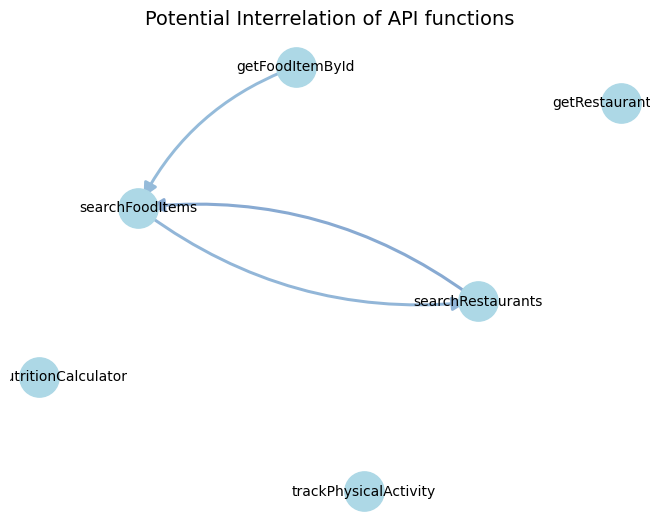

In [95]:
import networkx as nx
import matplotlib.pyplot as plt


def create_weighted_directed_graph(edges, nodes):
    graph = nx.DiGraph()
    graph.add_nodes_from(nodes)

    for edge in edges:
        source, target, _, weight = edge
        graph.add_edge(source, target, weight=weight)

    return graph


def gradient_color(t):
    light_blue = (173 / 255, 216 / 255, 230 / 255)  # RGB for light blue
    dark_blue = (0, 0, 139 / 255)  # RGB for dark blue

    r = light_blue[0] * (1 - t) + dark_blue[0] * t
    g = light_blue[1] * (1 - t) + dark_blue[1] * t
    b = light_blue[2] * (1 - t) + dark_blue[2] * t

    return (r, g, b)


def draw_graph(graph):
    pos = nx.spring_layout(graph, k=1.5)
    edge_weights = [graph[u][v]["weight"] for u, v in graph.edges()]
    edge_colors = [
        gradient_color(weight**3) for weight in edge_weights
    ]  # Exponentiation for better contrast on the graph
    edge_widths = [2 + (weight**3) for weight in edge_weights]
    nx.draw(
        graph,
        pos,
        with_labels=True,
        node_size=800,
        node_color="lightblue",
        font_size=10,
    )
    nx.draw_networkx_edges(
        graph,
        pos,
        edge_color="white",  # White color to hide default straight edges
        connectionstyle="arc3,rad=0.0",
        arrows=True,
        arrowstyle="-|>",
        arrowsize=20,
        width=4,
    )

    nx.draw_networkx_edges(
        graph,
        pos,
        edge_color=edge_colors,
        width=edge_widths,
        connectionstyle="arc3,rad=0.2",
        arrows=True,
        arrowstyle="-|>",
        arrowsize=20,
    )

    plt.title("Potential Interrelation of API functions", fontsize=14)
    plt.axis("off")
    plt.show()


weighted_graph = create_weighted_directed_graph(decoded_bonds, list(funcs.keys()))
draw_graph(weighted_graph)

In [97]:
decoded_bonds, list(funcs.keys())

([['searchFoodItems', 'searchRestaurants', 'query', 0.5381122],
  ['searchRestaurants', 'searchFoodItems', 'query', 0.59862816],
  ['getFoodItemById', 'searchFoodItems', 'foodItemId', 0.5145686]],
 ['searchFoodItems',
  'createNutritionCalculator',
  'getRestaurantMenu',
  'searchRestaurants',
  'trackPhysicalActivity',
  'getFoodItemById'])